# Dask DataFrame

## Лабораторная работа 13

In [1]:
import os, glob, json
import pandas as pd
import matplotlib.pyplot as plt

try:
    import dask
    import dask.dataframe as dd
    import dask.bag as db
    DASK_AVAILABLE = True
except Exception:
    DASK_AVAILABLE = False

print("DASK_AVAILABLE =", DASK_AVAILABLE)

DASK_AVAILABLE = True


1. В архиве `recipes_full.zip` находятся файлы, содержащие информацию об рецептах блюд. Загрузите данные из файлов этого архива в виде `dd.DataFrame` с названием `recipes`. Укажите, что в столбце `submitted` содержатся даты.

In [2]:
recipes_csv = sorted(glob.glob("recipes_full_*.csv"))

df = dd.read_csv(recipes_csv, assume_missing=True, parse_dates=["submitted"], blocksize=None)

for col in ["n_steps","minutes","n_ingredients"]:
    if col in df.columns:
        df[col] = df[col].map_partitions(pd.to_numeric, errors="coerce")

display(df)

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
npartitions=8,,,,,,,,
,float64,object,float64,float64,datetime64[ns],float64,object,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


2. Выведите метаинформацию о таблице: `npartitions` и типы столбцов.

In [5]:
print("npartitions =", df.npartitions)
display(df.dtypes)

npartitions = 8


id                       float64
name                      object
minutes                  float64
contributor_id           float64
submitted         datetime64[ns]
n_steps                  float64
description               object
n_ingredients            float64
dtype: object

3. Выведите на экран 5 первых строк таблицы. Выведите на экран 5 последних строк таблицы. В случае сообщения об ошибки объясните причину и исправьте ошибку.

In [7]:
display(df.head(5))
display(df.tail(5))

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
0,683970.0,vant ivoire mickies nothing,33.0,803776.0,2019-08-22,4.0,pat and gina neely and their family own and op...,9.0
1,1089012.0,kremsils mariposa baccala cookies class borage...,23.0,51579.0,2013-03-02,1.0,"a light, tasty and easy to put together chicke...",5.0
2,1428572.0,tania lander,0.0,68884.0,1980-11-09,1.0,a delicious melt in your mouth appetizer. for ...,5.0
3,1400250.0,heloise milli asher doogh zojirushi,24.0,678862.0,2018-04-29,3.0,delicious cream cheese and peach filled cresce...,1.0
4,387709.0,nutty chocolate chunk cookies,47.0,489552.0,2009-08-31,8.0,everyone loves these buttery cookies chock ful...,10.0


,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
278949,1029131.0,tuti waffle snackies steakhouse,19.0,171345.0,1973-10-18,4.0,"according to a providence journal article, ama...",4.0
278950,1700703.0,noelias cheats crocante fleisch zitumbuwa,1.0,30228.0,2007-07-01,6.0,if possible sauté the onions and garlic in abo...,1.0
278951,1910650.0,rubbed restuffed pelmeni bedouin flavourful,60.0,591905.0,2009-09-26,3.0,another great recipe to add to the growing swe...,2.0
278952,713836.0,stems polpettine peezi,NaN,357389.0,2003-09-30,4.0,adapted from top secret recipes. love this!,9.0
278953,660699.0,clementines,64.0,29196.0,1973-06-03,6.0,this would make a great start to your holiday ...,8.0


4. Посчитайте, сколько строк содержит каждый из блоков

In [9]:
rows_per_partition = df.map_partitions(len).compute()
display(pd.Series(rows_per_partition, name="rows").rename_axis("partition"))

partition
0    278955
1    278955
2    278955
3    278955
4    278955
5    278954
6    278954
7    278954
Name: rows, dtype: int64

5. Найдите максимум в столбце `n_steps`. Визуализируйте граф вычислений для этой задачи. Прокомментируйте логику работы `dask` в этом случае.

In [15]:
if "n_steps" not in df.columns:
    raise ValueError("Нет столбца 'n_steps'")
lazy_max = df["n_steps"].max()
try:
    lazy_max.visualize()
    print("Граф сохранён")
except Exception as e:
    print("Визуализация недоступна:", repr(e))
display(lazy_max.compute())

Граф сохранён


145.0

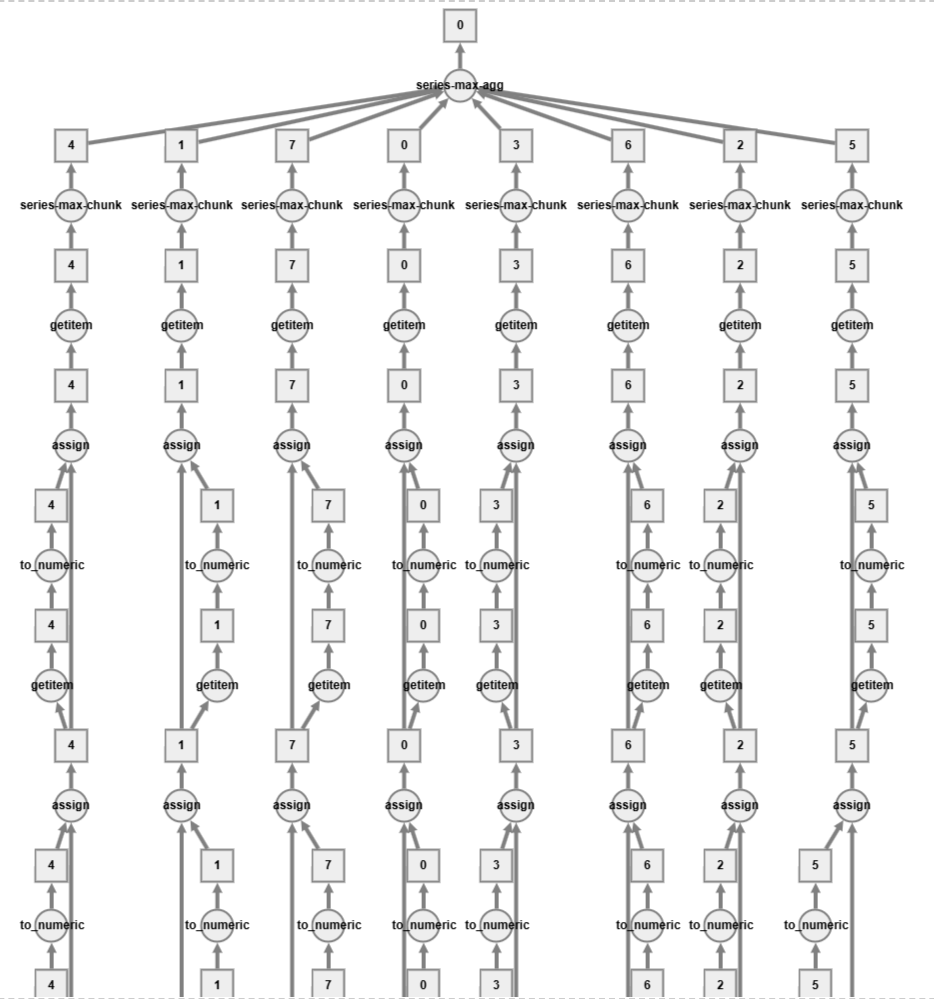
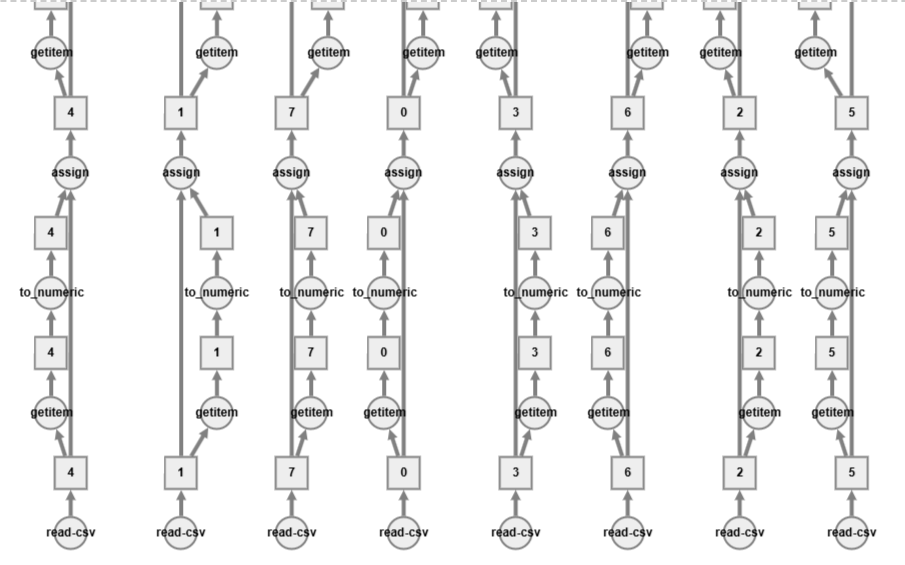

6. Посчитайте количество отзывов с группировкой по месяцам добавления отзыва в базу.

In [20]:
ym = df["submitted"].dt.strftime("%Y-%m")
recipes_per_month = df.groupby(ym).size().compute().sort_index()
recipes_per_month.name = "recipes_count"
display(recipes_per_month.head(12))

submitted
1970-01    3306
1970-02    2943
1970-03    3324
1970-04    3245
1970-05    3284
1970-06    3189
1970-07    3212
1970-08    3191
1970-09    3128
1970-10    3184
1970-11    3229
1970-12    3300
Name: recipes_count, dtype: int64

7. Считайте файлы из архива `reviews_full.zip` (__ЛР12__) в виде `dask.bag`. Пользуясь результатом лабораторной работы 12, рассчитайте среднее значение оценок отзывов с группировкой по месяцам. После завершения всех вычислений преобразуйте результат к `pd.Series`.

In [46]:
import re
reviews_globs = (
    sorted(glob.glob("reviews_*.json"))
)
DATA_GLOB = "reviews_*.json"
rating_re = re.compile(r"reviews_(\d+)\.json$")

In [48]:
mean_rating_series = pd.Series(dtype=float)
bag_raw = db.read_text(DATA_GLOB, include_path=True)     # (line, path)
bag = bag_raw.map(lambda lp: json.loads(lp[0]))

In [50]:
def parse_with_rating(lp):
    """
    lp = (line, path) из dask.bag с include_path=True
    line — строка JSON, path — полный путь к файлу
    """
    line, path = lp
    obj = json.loads(line)
    # гарантированно найдёт число из имени файла
    m = rating_re.search(path)
    if m:
        obj["rating"] = int(m.group(1))
    else:
        raise ValueError(f"Не удалось извлечь rating из имени файла: {path}")
    return obj

bag = bag_raw.map(parse_with_rating)

In [52]:
def to_pair(rec):
    d = rec.get("date")
    r = rec.get("rating")
    if d is None or r is None:
        return None
    ym = str(d)[:7]
    try: r = float(r)
    except Exception: return None
    return (ym, r)
pairs = bag.map(to_pair).filter(lambda x: x is not None)
def binop(acc, x): return (acc[0] + x[1], acc[1] + 1)
def combine(a, b): return (a[0] + b[0], a[1] + b[1])
agg = pairs.foldby(key=lambda x: x[0], binop=binop, initial=(0.0,0), combine=combine)
means = agg.map(lambda kv: (kv[0], kv[1][0]/kv[1][1] if kv[1][1] else float('nan'))).compute()
mean_rating_series = pd.Series(dict(means)).sort_index()

mean_rating_series.name = "mean_rating"
display(mean_rating_series.head(12))

1970-01    4.375000
1970-02    4.333333
1970-03    4.229167
1970-04    4.456140
1970-05    4.636364
1970-06    4.408163
1970-07    4.380597
1970-08    4.430464
1970-09    4.167939
1970-10    4.482234
1970-11    4.271277
1970-12    4.334821
Name: mean_rating, dtype: float64

8. Пользуясь результатами решения задач 6 и 7, создайте `pd.DataFrame`, содержащий два столбца: `mean_rating`, `recipes_count`

In [54]:
combined = pd.DataFrame({
    "mean_rating": mean_rating_series,
    "recipes_count": recipes_per_month
}).sort_index()
display(combined.head(12))

,mean_rating,recipes_count
1970-01,4.375000,3306
1970-02,4.333333,2943
1970-03,4.229167,3324
1970-04,4.456140,3245
1970-05,4.636364,3284
1970-06,4.408163,3189
1970-07,4.380597,3212
1970-08,4.430464,3191
1970-09,4.167939,3128
1970-10,4.482234,3184
